#  Project 1:  MTA Turnstile Data

This notebook contains code from Metis, Laura Chen, and Brian Kim.

The completed project consists of additional Jupyter notebooks by Chris Giler and Jeremy Brown within the same Github repository.

In [16]:
from __future__ import print_function, division

In [17]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from pylab import figure, axes, pie, title, show
import seaborn as sns

In [18]:
import datetime
from datetime import datetime

In [19]:
%matplotlib inline
from urllib.request import urlopen

In [20]:
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt'
df = pd.read_csv(url)
df.columns = df.columns.str.lower()

In [21]:
print (len(df))
# Removing Journal Square due to bad data
df = df[df.station != 'JOURNAL SQUARE']

print (len(df))

196861
196005


In [23]:
df['datetime'] = df['date'] + ' ' + df['time']
df["datetime"] = pd.to_datetime(df.date + " " +df.time, format="%m/%d/%Y %H:%M:%S")
df['Day'] = df['datetime'].dt.weekday_name

df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,Day
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/06/2017,00:00:00,REGULAR,6166390,2088519,2017-05-06 00:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/06/2017,04:00:00,REGULAR,6166420,2088525,2017-05-06 04:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/06/2017,08:00:00,REGULAR,6166433,2088557,2017-05-06 08:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/06/2017,12:00:00,REGULAR,6166514,2088663,2017-05-06 12:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/06/2017,16:00:00,REGULAR,6166791,2088720,2017-05-06 16:00:00,Saturday


In [32]:
mask = ['station', 'linename', 'scp', 'unit', 'c/a']
df_monthly=df.groupby(mask)[['entries']].max() - df.groupby(mask)[["entries"]].min()
df_monthly.head()

entries
station linename scp      unit c/a          
1 AV    L        00-00-00 R248 H007    18192
                 00-00-01 R248 H007    23212
                 00-03-00 R248 H007     7488
                 00-03-01 R248 H007     5583
                 00-03-02 R248 H007     6358

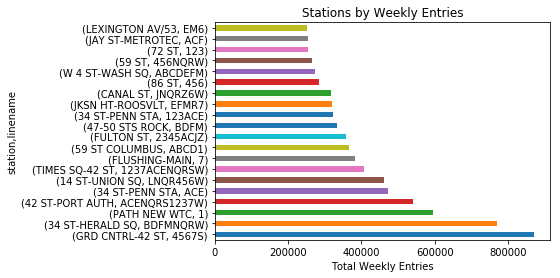

In [33]:
ax = df_monthly.groupby(['station','linename'])['entries'].sum()\
    .sort_values(ascending=False).head(20).plot(kind= 'barh',title="Stations by Weekly Entries")
ax.set_xlabel("Total Weekly Entries")

In [27]:
(df.groupby(["scp","station", "datetime","unit","c/a"])
 .entries.count()
 .reset_index()
 .sort_values("entries", ascending=False)).head(50)

df.drop_duplicates(subset=["c/a", "unit", "scp", "station", "datetime"],inplace=True)

In [28]:
df[["PREV_DATE", "PREV_ENTRIES"]] = (df
                                       .groupby(["c/a", "unit", "scp", "station"])["date", "entries"]
                                       .transform(lambda grp: grp.shift(1)))

In [29]:
df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [30]:
def get_daily_counts(row, max_counter):
    counter = row["entries"] - row["PREV_ENTRIES"]
    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"],row['c/a'],row['unit'],
             row['scp'],row['station'])
        # assumption is that 
        counter = min(row["entries"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
df["DAILY_ENTRIES"] = df.apply(get_daily_counts, axis=1, max_counter=1000000)

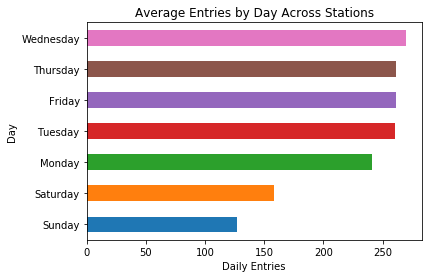

In [31]:
df=df[df['DAILY_ENTRIES']!=0]
ax = df.groupby('Day').DAILY_ENTRIES.mean().sort_values().plot(kind='barh',title="Average Entries by Day Across Stations");
ax.set_xlabel("Daily Entries");